In [1]:
import torch
import torch.distributions as dist
import neml2
from neml2.pyzag import interface
from pyzag import nonlinear, reparametrization, chunktime
import matplotlib.pyplot as plt
import tqdm

In [2]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

nchunk = 50

In [3]:
nrate = 5
ntemperature = 5
nbatch = nrate * ntemperature
max_strain = 0.25
ntime = 100
rates = torch.logspace(-6,0,nrate, device = device)
temperatures = torch.linspace(310.0,1190.0,ntemperature, device = device)

In [4]:
class SolveStrain(torch.nn.Module):
    """Just integrate the model through some strain history
    """
    def __init__(self, discrete_equations, nchunk = 1, rtol = 1.0e-6, atol = 1.0e-4):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.cached_solution = None
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, temperature, loading, cache = False):
        """Integrate through some time/temperature/strain history and return stress
        """
        if cache and self.cached_solution is not None:
            solver = nonlinear.RecursiveNonlinearEquationSolver(
                self.discrete_equations,
                step_generator=nonlinear.StepGenerator(self.nchunk),
                predictor=nonlinear.FullTrajectoryPredictor(self.cached_solution), nonlinear_solver = chunktime.ChunkNewtonRaphson(rtol = self.rtol, atol = self.atol)
            )
        else:
            solver = nonlinear.RecursiveNonlinearEquationSolver(
                self.discrete_equations, step_generator=nonlinear.StepGenerator(self.nchunk),
                predictor=nonlinear.PreviousStepsPredictor(), nonlinear_solver = chunktime.ChunkNewtonRaphson(rtol = self.rtol, atol = self.atol)
            )

        # We could pass this in as input, but it's easy enough to do here
        control = torch.zeros_like(loading)
        control[...,1:] = 1.0

        # Setup
        forces = self.discrete_equations.collect_forces({'t': time, 'T': temperature, 'fixed_values': loading, 'control': control})
        state0 = torch.zeros(forces.shape[1:-1] + (self.discrete_equations.nstate,), device = forces.device)

        result =  nonlinear.solve_adjoint(
            solver, state0, len(forces), forces
        )

        if cache:
            self.cached_solution = result.detach().clone()

        return result[...,0]

In [5]:
model = SolveStrain(interface.NEML2PyzagModel(neml2.load_model("demo_model.i", "implicit_rate"), exclude_parameters = ["elasticity.E", "elasticity.nu","R.X", "d.X", "mu.X", "mu.Y","yield_zero.sy"]))

In [6]:
time = torch.zeros((ntime, nrate, ntemperature, 1), device = device)
loading = torch.zeros((ntime, nrate, ntemperature, 6), device = device)
temperature = torch.zeros((ntime, nrate, ntemperature, 1), device = device)
for i, rate in enumerate(rates):
    time[:, i] = torch.linspace(0, max_strain / rate, ntime, device = device)[:, None, None]
    loading[:, i] = torch.linspace(0, max_strain, ntime, device = device)[:, None, None]
for i, T in enumerate(temperatures):
    temperature[:, :, i] = T
time = time.reshape((ntime, -1, 1))
temperature = temperature.reshape((ntime, -1, 1))
loading = loading.reshape((ntime, -1, 6))

In [7]:
# Replace with samples from normal
actual_cov = 0.025
actual_parameter_values = {}
for n,p in model.named_parameters():
    actual_parameter_values[n] = p.data.detach().clone().cpu()
    ndist = dist.Normal(p.data, torch.abs(p.data) * actual_cov).expand((nbatch,)+p.shape)
    p.data = ndist.sample().to(device)

In [8]:
with torch.no_grad():
    data = model(time, temperature, loading)

Text(0.5, 1.0, 'Input data -- all conditions')

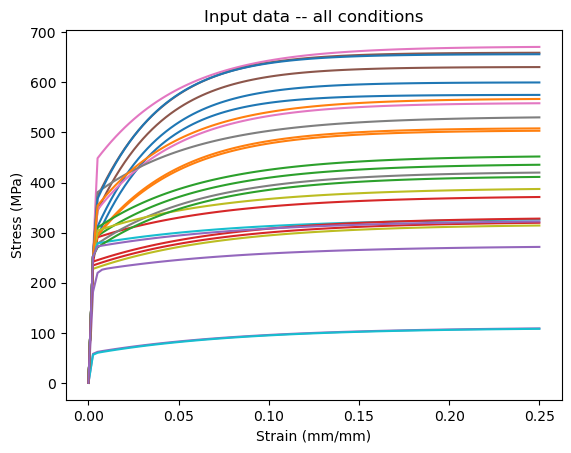

In [9]:
plt.plot(loading.cpu()[...,0], data.cpu())
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Input data -- all conditions")

In [10]:
# Now replace our original parameter with random values over a range
guess_parameter_values = {}
guess_cov = 0.2
for n, p in model.named_parameters():
    p.data = torch.normal(actual_parameter_values[n], torch.abs(actual_parameter_values[n])*guess_cov).to(device)
    guess_parameter_values[n] = p.data.detach().clone()

In [11]:
# Scale to get better performance
A_scaler = reparametrization.RangeRescale(torch.tensor(-12.0, device = device), torch.tensor(-4.0, device = device))
B_scaler = reparametrization.RangeRescale(
    torch.tensor(-1.0, device = device), torch.tensor(-0.5, device = device)
)
C_scaler = reparametrization.RangeRescale(torch.tensor(-8.0, device = device), torch.tensor(-3.0, device = device))
R_scaler = reparametrization.RangeRescale(
    torch.tensor([0.0,0.0,0.0,0.0], device=device), torch.tensor([500.0,500.0,500.0,500.0], device=device)
)
d_scaler = reparametrization.RangeRescale(
    torch.tensor([0.01, 0.01, 0.01, 0.01], device=device),
    torch.tensor([50.0, 50.0, 50.0, 50.0], device=device),
)

model_reparameterizer = reparametrization.Reparameterizer(
    {"discrete_equations.A_value": A_scaler,
     "discrete_equations.B_value": B_scaler,
     "discrete_equations.C_value": C_scaler,
     "discrete_equations.R_Y": R_scaler,
     "discrete_equations.d_Y": d_scaler}, error_not_provided=True)
model_reparameterizer(model)

In [12]:
# Generate the initial results so we know where we are starting from
with torch.no_grad():
    initial_results = model(time, temperature, loading)

Text(0.5, 1.0, 'Initial comparison')

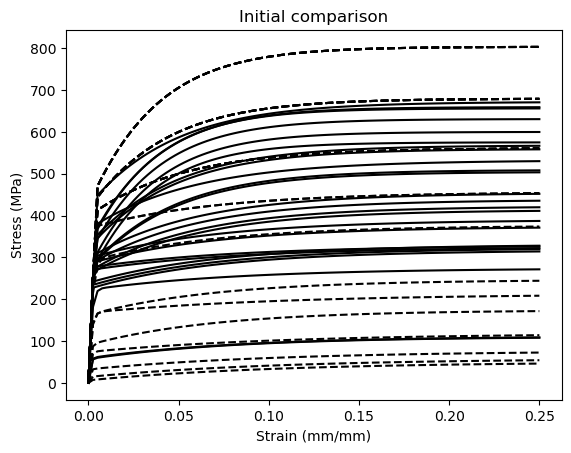

In [13]:
plt.plot(loading.cpu()[..., 0], data.cpu(), 'k-')
plt.plot(loading.cpu()[..., 0], initial_results.cpu(), 'k--')
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Initial comparison")

Loss: 4.24e+03: 100%|██████████| 20/20 [11:39<00:00, 34.97s/it]


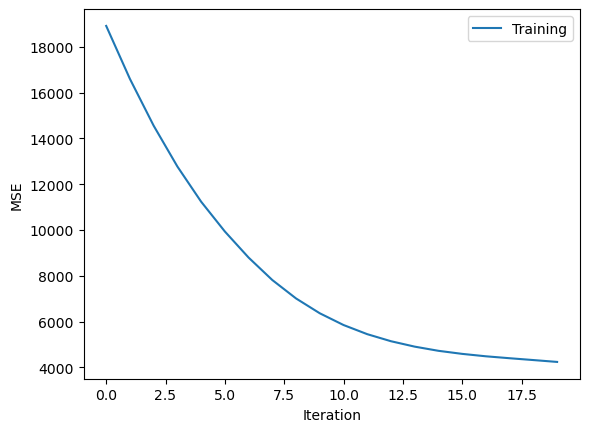

In [14]:
niter = 20
lr = 5.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

titer = tqdm.tqdm(range(niter))
titer.set_description("Loss:")
loss_history = []
for i in titer:
    optimizer.zero_grad()
    res = model(time, temperature, loading, cache = True)
    loss = loss_fn(res, data)
    loss.backward()
    loss_history.append(loss.detach().clone().cpu())
    titer.set_description("Loss: %3.2e" % loss_history[-1])
    optimizer.step()

plt.plot(loss_history, label="Training")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend(loc="best")

Text(0.5, 1.0, 'Final comparison')

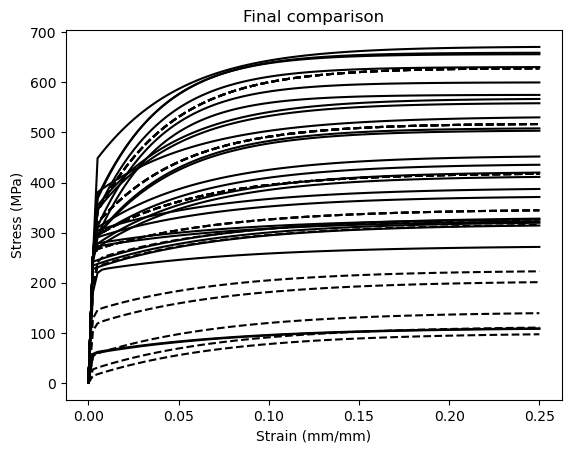

In [15]:
plt.plot(loading.cpu()[..., 0], data.cpu(), "k-")
plt.plot(loading.cpu()[..., 0], res.detach().cpu(), "k--")
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Final comparison")

In [16]:
print("The results:")
for n, p in model.discrete_equations.named_parameters():
    nice_name = n.split('.')[-2]
    ref_name = "discrete_equations." + nice_name
    scaler = model_reparameterizer.map_dict[ref_name]
    print(nice_name)
    print("\tInitial: \t" + str(guess_parameter_values[ref_name].cpu()))
    print("\tOptimized: \t" + str(scaler(p.data).cpu()))
    print("\tTrue value: \t" + str(actual_parameter_values[ref_name].cpu()))

The results:
A_value
	Initial: 	tensor(-11.6395)
	Optimized: 	tensor(-10.8406)
	True value: 	tensor(-8.6790)
B_value
	Initial: 	tensor(-0.5357)
	Optimized: 	tensor(-0.5000)
	True value: 	tensor(-0.7440)
C_value
	Initial: 	tensor(-5.0966)
	Optimized: 	tensor(-5.4487)
	True value: 	tensor(-5.4100)
R_Y
	Initial: 	tensor([340.2821, 207.8166,  93.7717,  41.9617])
	Optimized: 	tensor([301.3132, 176.9857,  82.2030,  90.4851])
	True value: 	tensor([300., 200., 100.,  50.])
d_Y
	Initial: 	tensor([28.9568, 23.8005, 15.9900,  9.3064])
	Optimized: 	tensor([25.0701, 20.6564, 14.6545, 14.1788])
	True value: 	tensor([30., 20., 15., 12.])
